# Results

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
import os
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from helpers import smooth_model_outputs, subsample_train

from matplotlib import gridspec
from sklearn.utils.class_weight import compute_sample_weight
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from vassi.classification import (
    plot_classification_timeline,
    plot_confusion_matrix,
    predict,
)
from vassi.config import cfg
from vassi.features import DataFrameFeatureExtractor
from vassi.io import from_yaml, load_dataset, save_dataset, save_data, load_data
from vassi.classification.results import DatasetClassificationResult
from vassi.utils import Experiment

import vassi._manuscript_utils as manuscript_utils
import vassi.visualization as vis

In [3]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = ("keypoints", "timestamps")

## Example train and test run

In [4]:
# load training and test datasets
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)

dataset_train = dataset_train.exclude_individuals(["intruder"])
dataset_test = dataset_test.exclude_individuals(["intruder"])

best_parameters = from_yaml("optimization/optimization-summary.yaml")
best_thresholds = [best_parameters[f"threshold-{category}"] for category in dataset_train.categories]

2025-06-20 15:26:38.607 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-06-20 15:26:39.426 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [5]:
# initialize a feature extractor from a configuration file
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("features-mice.yaml")

X_example_train, y_example_train = subsample_train(dataset_train, extractor, random_state=1, log=None)

In [6]:
sample_counts = pd.concat(
    (
        (
            dataset_train
            .observations.groupby("category")
            .aggregate(samples_train=("duration", "sum"))
        ),
        (
            dataset_test
            .observations.groupby("category")
            .aggregate(samples_test=("duration", "sum"))
        ),
        pd.DataFrame({"subsampled_train": pd.Series(*np.unique(y_example_train, return_counts=True)[::-1])})
    ),
    axis=1,
)

In [7]:
sample_counts = pd.concat(
    (
        sample_counts,
        (sample_counts / sample_counts.sum(axis=0) * 100).rename(columns=lambda column: f"{column} (%)")
    ),
    axis=1,
).iloc[:, [0, 3, 1, 4, 2, 5]]

sample_counts

,samples_train,samples_train (%),samples_test,samples_test (%),subsampled_train,subsampled_train (%)
attack,14039,2.765009,12630,4.818643,14035,13.674406
investigation,146615,28.876113,61275,23.377857,29999,29.228251
mount,28615,5.635781,31848,12.150763,28608,27.872989
none,318469,62.723097,156354,59.652737,29995,29.224354


In [8]:
sample_counts.to_csv("mice-samples.csv", index=False)

Uncomment the following code for a full training and test run of the CALMS21 dataset.

In [9]:
# # set a fixed random state for reproducible results
# random_state = np.random.default_rng(1)

# # subsample dataset and encode target from string to numeric
# X, y = subsample_train(
#     dataset_train,
#     extractor,
#     random_state=random_state,
#     log=None,
# )
# y = dataset_train.encode(y)

# # specify and fit classification model
# classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
#     X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
# )

# # use model for predictions on the test dataset
# test_result = predict(
#     dataset_test,
#     classifier,
#     extractor,
#     log=None,
# )

# # save the classification result as a dataset
# # additionally, apply a smoothing filter and custom decision thresholds

# save_dataset(
#     test_result.smooth(partial(smooth_model_outputs, best_parameters), decision_thresholds=best_thresholds).to_dataset(
#         trajectories={identifier: group.trajectories for identifier, group in dataset_test},
#         background_category="none",
#     ),
#     directory="../../datasets/CALMS21/pred",
#     dataset_name="mice_pred",
#     observation_suffix="predictions",
# )

Uncomment the following code to run all 20 test runs locally.  
Alternatively, download examples/CALMS21/results.h5 from our data repository or run `scripts/evaluation-mice.py` with parallelization using MPI.

In [10]:
# experiment = Experiment(20, random_state=1)

# for run in tqdm(experiment, total=experiment.num_runs):
#     X, y = subsample_train(
#         dataset_train,
#         extractor,
#         random_state=experiment.random_state,
#         log=None,
#     )
#     y = dataset_train.encode(y)

#     classifier = XGBClassifier(n_estimators=1000, random_state=experiment.random_state).fit(
#         X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
#     )

#     summary = []
#     y = {"true": {}, "pred": {}}

#     test_result = predict(dataset_test, classifier, extractor, log=None)
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="model_outputs",
#         )
#     )

#     test_result = test_result.smooth(partial(smooth_model_outputs, best_parameters))
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="smoothed",
#         )
#     )

#     test_result = test_result.threshold(best_thresholds, default_decision="none")
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="thresholded",
#         )
#     )

#     summary = pd.concat(summary, ignore_index=True)

#     y["true"]["timestamp"] = test_result.y_true_numeric
#     y["pred"]["timestamp"] = test_result.y_pred_numeric
#     y["true"]["annotation"] = dataset_test.encode(test_result.annotations["category"].to_numpy())
#     y["pred"]["annotation"] = dataset_test.encode(test_result.annotations["predicted_category"].to_numpy())
#     y["true"]["prediction"] = dataset_test.encode(test_result.predictions["true_category"].to_numpy())
#     y["pred"]["prediction"] = dataset_test.encode(test_result.predictions["category"].to_numpy())

#     experiment.add((summary, y))

# summary = pd.concat([summary for summary, _ in experiment.collect().values()], ignore_index=True)
# confusion = [y for _, y in experiment.collect().values()]

# for run, confusion_data in enumerate(confusion):
#     save_data("results.h5", confusion_data["true"], f"run_{run:02d}/true")
#     save_data("results.h5", confusion_data["pred"], f"run_{run:02d}/pred")
# save_data("results.h5", {"runs": np.array([f"run_{run:02d}" for run in range(len(confusion))])})
# summary.to_hdf("results.h5", key="summary")
# test_result.to_h5("results.h5", dataset_name="test_dataset")

In [11]:
summary = pd.read_hdf("results.h5", key="summary")
confusion = [load_data("results.h5", run) for run in load_data("results.h5", "runs")]
test_result = DatasetClassificationResult.from_h5("results.h5", dataset_name="test_dataset")

In [12]:
colors = [
    "#fc8d62",
    "#8da0cb",
    "#66c2a5",
    "#dddddd",
]
category_labels = ["att", "inv", "mnt", "other"]

## Per-frame F1 scores and evaluation

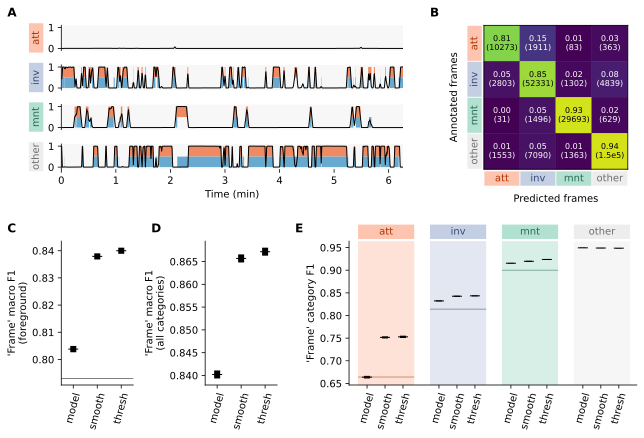

In [13]:
box_kwargs = {"lw": 0.0, "joinstyle": "round", "alpha": 0.5}

scores = manuscript_utils.aggregate_scores(summary, "timestamp_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (8, 5)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes=[1, 1], spacing_absolute=1, orientation="vertical")
top_left, top_right = top.divide(sizes_absolute=[0, 2.25], spacing_absolute=1, orientation="horizontal")
panels_timelines = top_left.divide(sizes=[1, 1, 1, 1], spacing=0.1, orientation="vertical")
panels_bottom = bottom.divide(sizes=[1, 1, 4], spacing_absolute=1, orientation="horizontal")

axes_timeline = [panel.get_ax(fig, label=label) for panel, label in zip(panels_timelines, ["A", None, None, None])]
ax_confusion = top_right.get_ax(fig, label="B", spines=(True, True, True, True))
ax_macro_foreground, ax_macro_all, ax_categories = [panel.get_ax(fig, label=label) for panel, label in zip(panels_bottom, ["C", "D", "E"])]

ax_macro_foreground.axhline(y=0.793, lw=1, c="grey")
manuscript_utils.plot_errorbars(
    ax_macro_foreground,
    *scores["macro-foreground"].to_numpy().T,
    ylabel="'Frame' macro F1\n(foreground)",
)
manuscript_utils.plot_errorbars(
    ax_macro_all,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Frame' macro F1\n(all categories)",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    ax_categories,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Frame' category F1",
)
for (idx, category), color, baseline in zip(enumerate(category_labels), colors, [0.664, 0.814, 0.900, None]):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_categories.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    if baseline is not None:
        ax_categories.hlines(
            baseline, x_left, x_right, lw=1, alpha=0.5, color=vis.adjust_lightness(color, 0.5), capstyle="butt"
        )
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_categories,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

dyad_results = test_result.classification_results[18].classification_results[("resident", "intruder")]
plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
    category_labels=category_labels,
    axes=axes_timeline,
)
for label, ax, color in zip(category_labels, axes_timeline, colors):
    ax.set_ylabel(None)
    vis.add_ytick_box(0.5, 1.4, ax, color=color, text=label, offset_in_inches=0.25, **box_kwargs)
ax.set_xlabel("Time (min)")


plot_confusion_matrix(
    [y["true"]["timestamp"] for y in confusion],
    [y["pred"]["timestamp"] for y in confusion],
    ax=ax_confusion,
    show_colorbar=False,
)
vis.add_xtick_boxes(range(4), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(4), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
ax_confusion.set_ylabel("Annotated frames", labelpad=25)
ax_confusion.set_xlabel("Predicted frames", labelpad=25)

plt.show()

## Interval-based F1 scores

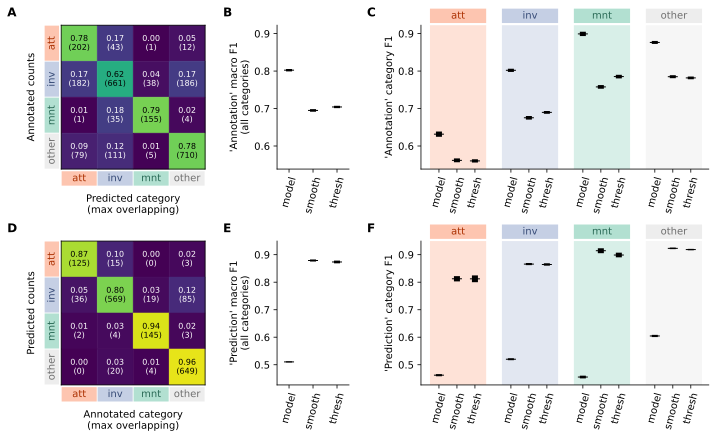

In [14]:
figsize = (9, 5)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes=[1, 1], spacing_absolute=1, orientation="vertical")
panels_top = top.divide(sizes_absolute=[2, 1, 4], spacing_absolute=1, orientation="horizontal")
panels_bottom = bottom.divide(sizes_absolute=[2, 1, 4], spacing_absolute=1, orientation="horizontal")

boxed = [True] * 4
classic = [True, True, False, False]
axes = [panel.get_ax(fig, label, spines=boxed if label in ["A", "D"] else classic) for panel, label in zip(panels_top + panels_bottom, ["A", "B", "C", "D", "E", "F"])]

# on annotation interval level

plot_confusion_matrix(
    [y["true"]["annotation"] for y in confusion],
    [y["pred"]["annotation"] for y in confusion],
    ax=axes[0],
    category_labels=category_labels,
    show_colorbar=False,
)
vis.add_xtick_boxes(range(4), 0.975, axes[0], labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(4), 0.975, axes[0], labels=category_labels, colors=colors, **box_kwargs)
axes[0].set_ylabel("Annotated counts", labelpad=25)
axes[0].set_xlabel("Predicted category\n(max overlapping)", labelpad=25)

scores = manuscript_utils.aggregate_scores(summary, "annotation_f1", categories=dataset_test.categories)
manuscript_utils.plot_errorbars(axes[1], *scores["macro-all"].to_numpy().T, ylabel="'Annotation' macro F1\n(all categories)")

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    axes[2],
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Annotation' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    axes[2].axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        axes[2],
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )


# on prediction interval level

plot_confusion_matrix(
    # plot matrix transposed for easier interpretation
    np.array([y["pred"]["prediction"] for y in confusion], dtype=object),
    np.array([y["true"]["prediction"] for y in confusion], dtype=object),
    ax=axes[3],
    category_labels=category_labels,
    show_colorbar=False,
)
vis.add_xtick_boxes(range(4), 0.975, axes[3], labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(4), 0.975, axes[3], labels=category_labels, colors=colors, **box_kwargs)
axes[3].set_xlabel("Annotated category\n(max overlapping)", labelpad=25)
axes[3].set_ylabel("Predicted counts", labelpad=25)

scores = manuscript_utils.aggregate_scores(summary, "prediction_f1", categories=dataset_test.categories)
manuscript_utils.plot_errorbars(axes[4], *scores["macro-all"].to_numpy().T, ylabel="'Prediction' macro F1\n(all categories)")

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    axes[5],
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Prediction' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    axes[5].axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        axes[5],
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

axes[1].sharey(axes[2])
axes[4].sharey(axes[5])

In [15]:
scores = []
formatted = {}

for f1 in ["timestamp", "annotation", "prediction"]:
    aggregated = manuscript_utils.aggregate_scores(summary, f"{f1}_f1", categories=dataset_test.categories).reset_index()
    aggregated["f1"] = f1
    scores.append(aggregated.set_index("f1"))

scores = pd.concat(scores).reset_index()
formatted["F1"] = scores["f1"]
formatted["Postprocessing step"] = scores["postprocessing_step"]

for column in scores.columns.droplevel(1)[2:]:
    column_formatted = column.replace("-", " (")
    if "(" in column_formatted:
        column_formatted += ")"
    column_formatted = column_formatted.replace("_", " ")
    formatted[column_formatted.capitalize()] = scores[column].apply(lambda values: f"{values["mean"]:.03f}±{values["std"]:.03f}", axis=1)

formatted = pd.DataFrame(formatted)
formatted.map(lambda s: s.replace("_", " ").capitalize())

,F1,Postprocessing step,Macro (foreground),Macro (all),Attack,Investigation,Mount,None
0,Timestamp,Model outputs,0.804±0.001,0.840±0.001,0.664±0.003,0.832±0.001,0.915±0.001,0.949±0.000
1,Timestamp,Smoothed,0.838±0.001,0.866±0.001,0.752±0.002,0.843±0.001,0.920±0.001,0.949±0.000
2,Timestamp,Thresholded,0.840±0.001,0.867±0.001,0.753±0.003,0.843±0.001,0.924±0.001,0.949±0.000
3,Annotation,Model outputs,0.778±0.004,0.802±0.003,0.632±0.007,0.802±0.004,0.899±0.006,0.877±0.004
4,Annotation,Smoothed,0.665±0.004,0.695±0.003,0.562±0.005,0.675±0.005,0.758±0.005,0.785±0.004
5,Annotation,Thresholded,0.678±0.003,0.704±0.003,0.560±0.004,0.690±0.004,0.785±0.005,0.782±0.004
6,Prediction,Model outputs,0.479±0.002,0.510±0.002,0.462±0.004,0.520±0.004,0.455±0.005,0.604±0.004
7,Prediction,Smoothed,0.864±0.005,0.879±0.004,0.812±0.010,0.866±0.004,0.914±0.009,0.923±0.003
8,Prediction,Thresholded,0.858±0.006,0.874±0.005,0.812±0.012,0.864±0.004,0.899±0.008,0.919±0.002


In [16]:
formatted.to_csv("mice-results.csv", index=False)

## All test dataset predictions

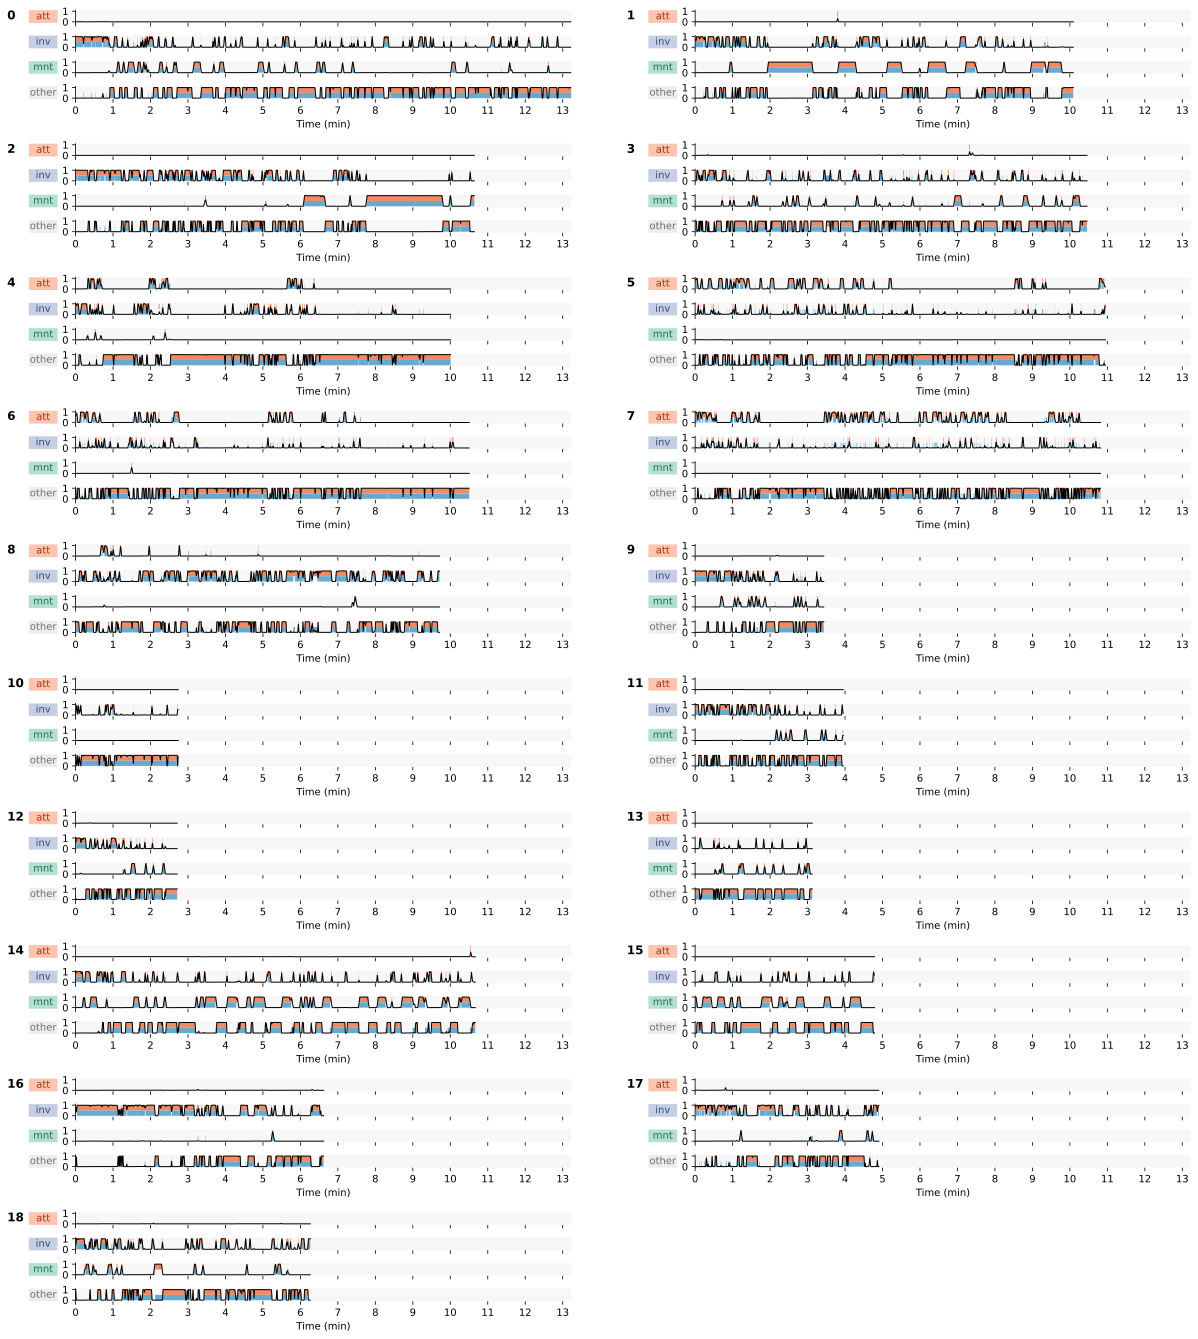

In [17]:
num_sequences = 19
interval = (0, test_result.predictions["stop"].max())

fig = plt.figure(figsize=(20, 45), dpi=150)
gs = plt.GridSpec(num_sequences, 2, figure=fig, hspace=0.5, wspace=0.25)

for sequence_idx in range(19):
    gs_inner = gridspec.GridSpecFromSubplotSpec(
        num_categories,
        1,
        subplot_spec=gs[sequence_idx // 2, sequence_idx % 2],
        hspace=1,
    )
    axes = gs_inner.subplots(sharex=True)

    dyad_results = test_result.classification_results[sequence_idx].classification_results[("resident", "intruder")]
    plot_classification_timeline(
        dyad_results.predictions,
        dyad_results.categories,
        annotations=dyad_results.annotations,
        timestamps=dyad_results.timestamps,
        y_proba_smoothed=dyad_results.y_proba_smoothed,
        interval=(-np.inf, np.inf),
        category_labels=category_labels,
        axes=axes,
    )
    axes[-1].set_xlim(interval)
    x_ticks = np.arange(*interval, 30 * 60)
    axes[-1].set_xticks(x_ticks)
    axes[-1].set_xticklabels(np.arange(x_ticks.size, dtype=int))
    axes[-1].set_xlabel("Time (min)")

    for label, ax, color in zip(category_labels, axes, colors):
        ax.set_ylabel(None)
        vis.add_ytick_box(0.5, 1.2, ax, color=color, text=label, offset_in_inches=0.25, width_in_inches=0.4, text_rotation=0, **box_kwargs) 

    fig.text(
        0,
        1,
        f"{sequence_idx}",
        transform=(axes[0].transAxes + transforms.ScaledTranslation(-0.95, 0, fig.dpi_scale_trans)),
        fontsize=12,
        va="top",
        weight="semibold",
    )

plt.show()